<a href="https://colab.research.google.com/github/christinawanggg/ait-dl-deepfake/blob/main/AIT_DL_Project_Extra_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIT Fall 2021 Deep Learning Final Project - Deepfake Detection

Scaffolding and assignment completed by Christina Wang and Isabel Grondin.

In [1]:
# Loading Libraries
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import os
import tensorflow as tf
from keras.preprocessing import image
from keras.utils import np_utils
from skimage.transform import resize
from PIL import Image

from tensorflow import keras
model = tf.keras.models.Sequential()


# Data Set

*   Celeb Deepfake 1: https://drive.google.com/file/d10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd/view


The Celeb Deepfake 1 dataset includes a combination of 1203 real and fake/synthesized videos of celebrities from Youtube. The current state of our project is utilizing this data set.

## Data Extraction

First, we needed to extract all of the videos in the data from a zip file.



In [2]:
# Imports needed for data extraction
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile


In [3]:
# using Pydrive to connect to Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

In [4]:
file_id = "10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd"
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % file_id}).GetList()

In [5]:
downloaded = drive.CreateFile({'id': "10NGF38RgF8FZneKOuCOdRIsPzpC7_WDd"})
downloaded.GetContentFile('Celeb-DF.zip')

In [6]:
# extracting all the videos from the zip file

zip = zipfile.ZipFile("Celeb-DF.zip")
zip.extractall()
videoNameList = zip.namelist()

# Data Pre-Processing

We parsed the videos into individual jpg frames. We then resized and cropped the images so that they all shared the same dimensions. Finally, we extracted the images into a pixel array format and flattened the shape of all the images. 

In [7]:
# Imports needed for standardizing data set
import cv2
import math
from PIL import Image

In [8]:
# Cleaning up the data set

videoNameList.remove("Celeb-real/")
videoNameList.remove("Celeb-synthesis/")
videoNameList.remove("YouTube-real/")
videoNameList.remove("List_of_testing_videos.txt")

In [9]:
# Balancing data set

drop_list = []
for i in range(len(videoNameList)):
  if 'Celeb-synthesis' in videoNameList[i]:
    drop_list.append(videoNameList[i])

for j in range(len(drop_list)):
  if j % 2 != 0:
    curr = drop_list[j]
    videoNameList.remove(curr)


In [11]:
# Extracting an individual frame or jpg image from each video

videos_dict = {} # used to see both the video name and resulting filename
videos_frames = []
videos_listY = [] # serving as our 'Y'
count = 0


for i in range(len(videoNameList)):
  videoFile = "/content/" + videoNameList[i]
  cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
  frameRate = cap.get(5) # frame rate
  x=1
  results = []
  videos_dict[videoNameList[i]] = []
  frame_count = 1
  for j in range(1,10,1):
    frameId = cap.get(j) # current frame number
    ret, frame = cap.read()
    filename ="frame%d-%d.jpg" % (count,frame_count)
    cv2.imwrite(filename, frame)
    videos_dict[videoNameList[i]].append(filename)
    videos_frames.append(filename) 
    frame_count += 1
  if 'real' in videoNameList[i]:
    results.append(1)
  elif 'synthesis' in videoNameList[i]:
    results.append(0)
  videos_listY.append(results)
  count+=1
  
cap.release()

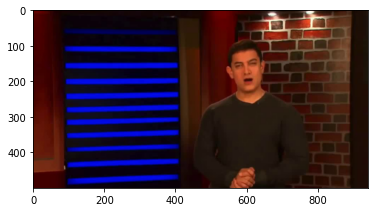

In [13]:
# Displaying a real image

img = plt.imread('frame0-1.jpg')
plt.imshow(img)


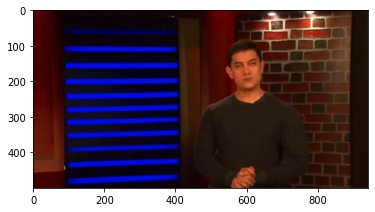

In [14]:
# Displaying a real image but different frame

img = plt.imread('frame0-5.jpg')
plt.imshow(img)


In [15]:
# Standardizing the mode of the images 

def changeColor(colorType):
  sizes = {}
  for i in range(len(videos_frames)):
    curr_image = Image.open(videos_frames[i])
  
    if curr_image.mode != colorType:
      png = curr_image.convert(colorType)
      background = Image.new(colorType, png.size, (255))
      png.save(videos_frames[i])

      sizes[videos_frames[i]] = curr_image.size

changeColor('RGB')

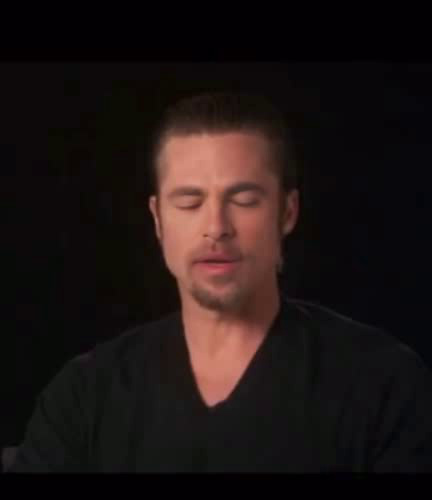

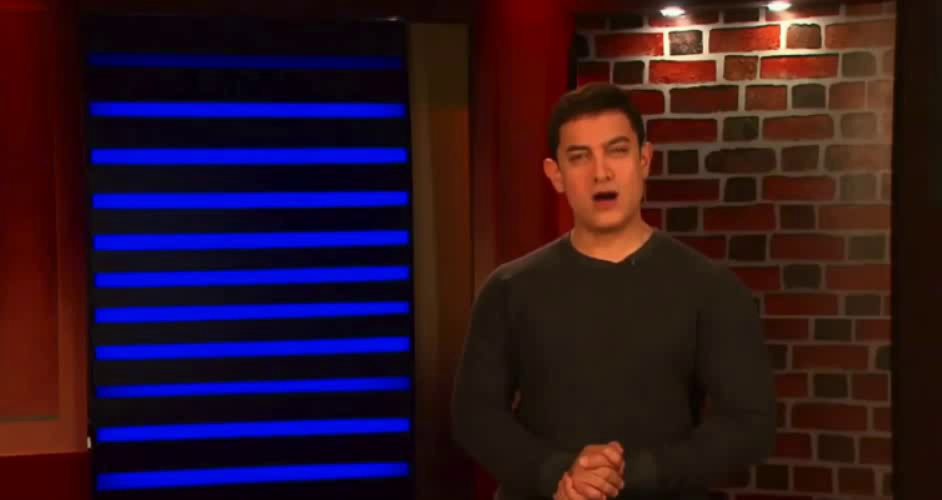

In [16]:
# Looking at the different dimensions of the images

img = Image.open('frame315-1.jpg')
display(img)

img2 = Image.open('frame0-1.jpg')
display(img2)

In [17]:
# Cropping all of the images into a square before scaling them down to 299x299

videos_listX = []
counter = 0

for key,value in videos_dict.items():
  frames = []
  for i in range(0,9,1):
    im = Image.open(videos_dict[key][i])
    width, height = im.size   # Get dimensions

    left = (width - 500)/2
    top = (height - 500)/2
    right = (width + 500)/2
    bottom = (height + 500)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    im.thumbnail((299,299))

    data = np.array(im)
    frames.append(data)
    counter += 1
  videos_listX.append(frames)

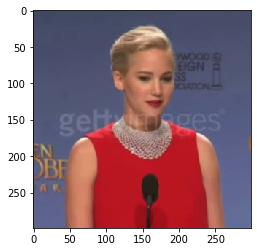

In [18]:
# Displaying new image proportions

plt.imshow(videos_listX[35][2], interpolation='nearest')

### Splitting The Data

Splitting the data into train and test sets.


In [19]:
# Imports needed to split the data
from sklearn.model_selection import train_test_split

In [20]:
# Do a train-test split
X_train, X_test, Y_train, Y_test = train_test_split(videos_listX, videos_listY, test_size=0.4, random_state=2)

In [21]:
# Splitting valid and train data
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=2)

In [22]:
# Converting lists to numpy arrays

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)

X_testoriginal = X_test

In [23]:
# Confirming successful split 

print(X_train.shape)
print(X_valid.shape)

(386, 9, 299, 299, 3)
(97, 9, 299, 299, 3)


# Training the Data

Training the data and running it through our model. We used an LSTM RNN with InceptionV3 as the base model.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model # Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import confusion_matrix


# CNN
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, ConvLSTM2D, Input, TimeDistributed, LSTM

In [25]:
print('# images in X_train: ', len(X_train))
print('# images in X_test: ', len(X_test))
print('# images in X_valid: ', len(X_valid))

# images in X_train:  386
# images in X_test:  323
# images in X_valid:  97


In [47]:
video = Input(shape=(9, 299, 299,3), dtype="bool")

In [51]:
cnn_base = InceptionV3(input_shape=(299,299, 3), weights="imagenet", include_top=False)
cnn_out = GlobalAveragePooling2D()(cnn_base.output)
cnn = Model(inputs=cnn_base.input, outputs=cnn_out)
cnn.trainable = False
encoded_frames = TimeDistributed(cnn)(video)
encoded_sequence = LSTM(128)(encoded_frames)
hidden_layer = Dense(128, activation="relu")(encoded_sequence)
dropout =(Dropout(0.2))(hidden_layer)
outputs = Dense(1, activation="sigmoid")(dropout)
model = Model([video], outputs)

In [52]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9, 299, 299, 3)]  0         
                                                                 
 time_distributed_3 (TimeDis  (None, 9, 2048)          21802784  
 tributed)                                                       
                                                                 
 lstm_3 (LSTM)               (None, 128)               1114624   
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                           

In [53]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

In [54]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True) # early stopping avoids overfitting

In [55]:
# Convert to float after resizing images

X_valid = X_valid.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [56]:
# 9 frames corresponding to 1 result

print(len(X_train[9]))
print(len(Y_train[9]))

9
1


In [57]:
history = model.fit(X_train, Y_train, epochs=10000000, callbacks=[es], validation_data=(X_valid,Y_valid))

Epoch 1/10000000
13/13 [==============================] - 470s 36s/step - loss: 0.7021 - accuracy: 0.5544 - val_loss: 0.6982 - val_accuracy: 0.5773
Epoch 2/10000000
13/13 [==============================] - 453s 35s/step - loss: 0.6504 - accuracy: 0.6036 - val_loss: 0.6719 - val_accuracy: 0.5773
Epoch 3/10000000
13/13 [==============================] - 459s 36s/step - loss: 0.6142 - accuracy: 0.6606 - val_loss: 0.6943 - val_accuracy: 0.5876
Epoch 4/10000000
13/13 [==============================] - 455s 35s/step - loss: 0.6187 - accuracy: 0.6347 - val_loss: 0.6490 - val_accuracy: 0.6392
Epoch 5/10000000
13/13 [==============================] - 452s 35s/step - loss: 0.5735 - accuracy: 0.7513 - val_loss: 0.6507 - val_accuracy: 0.6392
Epoch 6/10000000
13/13 [==============================] - 454s 35s/step - loss: 0.5538 - accuracy: 0.6969 - val_loss: 0.6325 - val_accuracy: 0.7113
Epoch 7/10000000
13/13 [==============================] - 454s 35s/step - loss: 0.5051 - accuracy: 0.7306 - val_

In [58]:
model.evaluate(X_test, Y_test)

11/11 [==============================] - 302s 27s/step - loss: 0.6077 - accuracy: 0.6502


[0.607742190361023, 0.6501547694206238]

# Predict + Evaluate

Running predictions and evaluating our results. Here we are looking at the confusion matrix to calculate the precision, recall, and f1 scores.



In [59]:
# Percentage of real to fake images in the test set
fake = 0
real = 0
for i in range(len(Y_test)):	
  if Y_test[i] == 0:		
    fake += 1
  elif Y_test[i] == 1:	
    real += 1
    
print("fake: ", fake, "real: ", real)

print("Real: ", real/(fake+real))
print("Fake: ", (fake/(fake+real)))

fake:  167 real:  156
Real:  0.48297213622291024
Fake:  0.5170278637770898


In [60]:
preds = model.predict(X_test)
preds_label = np.rint(preds)

Our prediction [0.]
Actual result [0]
AxesImage(54,36;334.8x217.44)


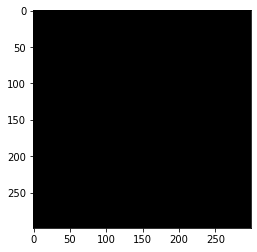

In [70]:
# Good prediction: This is a fake image and our model predictied it correctly!

print("Our prediction",preds_label[5])
print("Actual result",Y_test[5])
print(plt.imshow(X_test[5][3]))

Our prediction [0.]
Actual result [1]
AxesImage(54,36;334.8x217.44)


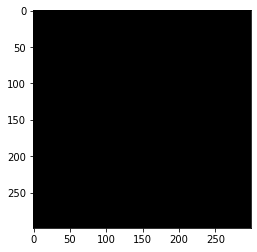

In [71]:
# Bad Prediction: this image is real, but we predicted it was fake. 

print("Our prediction",preds_label[205])
print("Actual result",Y_test[205])
print(plt.imshow(X_test[205][3]))

In [63]:
tn, fp, fn, tp = confusion_matrix(Y_test, preds_label).ravel()
print("True Negative",tn)
print("True Postive",tp)
print("False Negative",fn)
print("False Positive",fp)

True Negative 109
True Postive 101
False Negative 55
False Positive 58


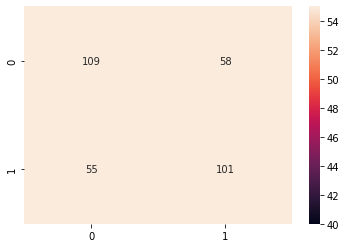

In [64]:
conf = confusion_matrix(Y_test,preds_label)
sns.heatmap(conf, annot=True, fmt="d", vmax=40)

In [65]:
# precision, recall, f1
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = (2 * precision * recall)/(precision + recall)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Precision:  0.6352201257861635
Recall:  0.6474358974358975
F1 Score:  0.6412698412698412


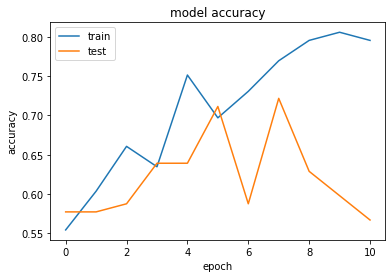

In [69]:
# Summarize for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Previous Models

We are some models we previously tried before coming to our current model.

In [ ]:
# Model #1 - CNN model
# This was our first model attempt - just using CNN. The accuracy was only .67
# on our test set. This model was not doing any better than guessing since our
# data set was a 70-30 split fake-real when we evaluated with it. Now we have
# fixed it to be about 50-50

model = Sequential()
model.add(Conv2D(16, 10, input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3],), # (721, 188, 354)
                activation='relu', kernel_initializer='he_normal'))  # output filter size = 6x6, kernel size = 5x5
model.add(BatchNormalization())  #improves results
model.add(MaxPool2D()) #pooling
model.add(Dropout(0.25))
model.add(Conv2D(32, 10, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten()) # flatten to go into the fully connected model
model.add(Dense(60, activation='relu', kernel_initializer='he_normal')) # fully connected model
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid')) # output

model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')

model.fit(X_train, Y_train, epochs = 10000000000000000, 
          callbacks=[es],
          batch_size=256, shuffle=True,
          validation_split=0.2)

In [ ]:
# Model #2 - ConvLSTM with Sequential model

model = Sequential()
model.add(ConvLSTM2D(filters =8, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(80, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(7, activation = "sigmoid"))

In [ ]:
seq_len = 7
img_height = 299
img_width = 299

In [ ]:
# Model #3 - ConvLSTM with InceptionV3 model

base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = ConvLSTM2D(filters =8, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3))
x = Dropout(0.25)(x)
x = Flatten()
x = GlobalAveragePooling2D()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.25)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

NameError: ignored